
**Santiago Gonzalez Toral - Student No. 15111227 - [hernan.toral.15@ucl.ac.uk](mailto:hernan.toral.15@ucl.ac.uk)**

**MSc. Web Science and Big Data Analytics **

# Part B

## Aim

The objective of this assignment is to test regression and logistic regression trained via gradient descent on the <a href="https://archive.ics.uci.edu/ml/datasets/Spambase" target="_blank">Spambase</a> data set.

## System Requirements

1. To open and run this notebook it is neccesary to have installed Python 3.x the Jupyter Notebook (iPython).
2. the Spambase data set should be stored in the _data_ folder and should be located in the same directory as the notebook file (.ipynb file).

## Process

### Initialization of the environment

In [49]:
LOGGING_MODE = False
import math
import numpy as np
from itertools import chain
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Data set loading

In order to prepare the data set for the trainer, an implementation of the basic statistic functions was developed in order to perform a feature normalization (z-score) when loading the data set.

In [2]:
class MyStats:
    
    def mean(self, values):
        totalSum = 0.0
        arrayLength = len(values)
        for value in values:
            totalSum += value
            
        return totalSum / arrayLength
    
    def variance(self, values):
        totalSum = 0.0
        arrayLength = len(values)
        mean = self.mean(values)
        for value in values:
            totalSum += (value - mean) ** 2
        return totalSum / (arrayLength-1)
    
    def std(self, values):
        return math.sqrt(self.variance(values))

To improve convergence performance of the online learners, the data set examples were shuffled to randomize their position in the training set.

In [3]:
rawdata = np.loadtxt('data/spambase.data', dtype="float", delimiter=",") #loading full dataset
totalRows = rawdata.shape[0]
totalFeatures = rawdata.shape[1] - 1
#feature normalization
mystat = MyStats()
i = 0
while i < totalFeatures:
    mu = mystat.mean(rawdata[:,i])
    std = mystat.std(rawdata[:,i])
    rawdata[:,i] = ( rawdata[:,i] - mu ) / std #z-score
    i+=1
np.random.shuffle(rawdata) # randomly shuffles the data

### Training Algorithms: Linear Regression and Logistic Regression

In [4]:
class Data:
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

'''
    Model Interface
'''
class Model:
    
    data = []
    theta = []
    
    def __init(self):
        print('initialize Model')
    
    def execute(self, gradient, label):
        print('This method must be overriden')
        return None
        
    def setData(self, train_data, test_data):
        self.data = Data()
        self.data.y_train = train_data[:,-1]
        bias = np.ones((train_data.shape[0],1))
        self.data.X_train = np.delete(np.append(bias, train_data, 1), -1, 1)
        
        self.data.y_test = test_data[:,-1]
        bias = np.ones((test_data.shape[0],1))
        self.data.X_test = np.delete(np.append(bias, test_data, 1), -1, 1)
        
    def initializeWeights(self, theta):
        self.theta = theta

    def getHypothesisFcn(self, isTrain):
        if(isTrain):
            return self.data.X_train * self.theta
        else:
            return self.data.X_test * self.theta
    
    def getElementWiseHypothesisFcn(self, index):
        return np.asscalar(self.data.X_train[index] * self.theta)
  
    def costFcn(self, isTrain):
        print('This method must be overriden')
        return None
    
    def predict(self, x, theta):
        bias = np.ones((1, 1))
        x = np.append(bias, np.asmatrix(x), 1)
        return np.asscalar(x * np.asmatrix(theta).T)
        
'''
    Implementation of Linear Regression
'''
class LinearRegression(Model):
    
    def __init(self):
        print("Running Linear Regression")
        super(LinearRegression, self).__init__()
        
    def execute(self, gradient, label):
        return gradient.runGradient(self, label)
    
    def costFcn(self, isTrain):
        if(isTrain):
            return (1/(2*(self.data.X_train.shape[0]))) * \
                         np.sum( np.power( ( self.getHypothesisFcn(isTrain) - self.data.y_train ), 2) )
        else:
            return (1/(2*(self.data.X_test.shape[0]))) * \
                         np.sum( np.power(( self.getHypothesisFcn(isTrain) - self.data.y_test ), 2) )

'''
    Implementation of Logistic Regression
'''
class LogisticRegression(Model):
    
    def __init(self, theta):
        print("Running Logistic Regression")
        super(LogisticRegression, self).__init__(np.zeros((train_data.shape[1],1)))
        
    def execute(self, gradient, label):
        return gradient.runGradient(self, label)
    
    def costFcn(self, isTrain):
        if(isTrain):
            return (-1/(self.data.X_train.shape[0])) * \
                   ( (self.data.y_train.T * np.log(self.getHypothesisFcn(isTrain))) + \
                     ((1-self.data.y_train.T) * np.log( 1-self.getHypothesisFcn(isTrain) ))
                   )
        else:
            return (-1/(self.data.X_test.shape[0])) * \
                   ( (self.data.y_test.T * np.log(self.getHypothesisFcn(isTrain))) + \
                     ((1-self.data.y_test.T) * np.log( 1-self.getHypothesisFcn(isTrain) ))
                   )
    
    def getHypothesisFcn(self, isTrain):
        fcn = super(LogisticRegression, self).getHypothesisFcn(isTrain) * -1
        return ( 1 / (1 + np.exp(fcn)) )
    
    def getElementWiseHypothesisFcn(self, index):
        fcn = super(LogisticRegression, self).getElementWiseHypothesisFcn(index) * -1
        return ( 1 / (1 + np.exp(fcn)) )      

### Gradient Descent Algorithms

In [5]:
'''
    Gradient Descent Interface
'''
class Gradient:
    
    alpha = 0 #learning rate
    epochs = 0 #total iterations
    convergenceCriterion = 0 #minimum MSE value to converge
    #historic values through epochs
    theta_history = []
    MSE_train_history = []
    MSE_test_history = []
    
    plotter = None
    lastEpoch = 0
    
    def __init__(self, epochs, alpha, convergenceCriterion, plotter):
        self.alpha = alpha
        self.epochs = epochs
        self.convergenceCriterion = convergenceCriterion
        
        self.theta_history = np.zeros((epochs, 1)) * float('inf')
        self.MSE_train_history = np.zeros((epochs, 1)) * float('inf')
        self.MSE_test_history = np.zeros((epochs, 1)) * float('inf')
        
        self.plotter = plotter
        self.lastEpch = 0
        
        print("Running gradient descent with learning rate: %06f" % self.alpha)
        
    def runGradient(self, model, label):
        print('This method must be overridden')
        return None
    
    def computeCost(self, j, model): 
        self.MSE_train_history[j] = model.costFcn(True)
        self.MSE_test_history[j] = model.costFcn(False)
        
    def plotEpoch(self, label):
        self.plotter.add2DPlot(np.linspace(1, self.lastEpoch, self.lastEpoch), 
                               self.MSE_train_history[0:self.lastEpoch], label, True) \
                    .add2DPlot(np.linspace(1, self.lastEpoch, self.lastEpoch), 
                               self.MSE_test_history[0:self.lastEpoch], label, False)

'''
    Implementation of Batch Gradient Descent Algorithm
'''
class BatchGradientDescent(Gradient):
    
    def runGradient(self, model, label):

        m = model.data.X_train.shape[0]
        theta_history = model.theta
        MSE_history = float('inf')
        for n in np.arange(self.epochs):
            h_theta = model.getHypothesisFcn(True)
            for j in np.arange(model.theta.shape[0]):
                model.theta[j] = model.theta[j] - ((self.alpha/m) 
                                                   * np.sum( 
                                                        np.multiply((h_theta - model.data.y_train), 
                                                               model.data.X_train[:,j]
                                                              )
                                                    )
                                                  )
            theta_history = np.append(theta_history, model.theta, 0)
            self.computeCost(n, model)
            
            if(LOGGING_MODE):
                print('MSE during epoch %2i -> train: %.6f test: %.6f' \
                      %(n, self.MSE_train_history[n], self.MSE_test_history[n]))
            
            self.lastEpoch = n
            if(abs(MSE_history - self.MSE_train_history[n]) < self.convergenceCriterion):
                print('Premature stoopage at epoch %i due to model reached convergence criterion' % n)
                break
            MSE_history = self.MSE_train_history[n]            
        
        self.plotEpoch(label)
        return model.theta.T

import time
'''
    Implementation of Stochastic Gradient Descent Algorithm
'''
class StochasticGradientDescent(Gradient):
    
    def runGradient(self, model, label):

        m = model.data.X_train.shape[0]
        X_train = model.data.X_train.tolist()
        y_train = list(chain.from_iterable( model.data.y_train.tolist() ))
        MSE_history = float('inf')
        for n in np.arange(self.epochs):
            start = time.time()
            theta_temp = list(chain.from_iterable( model.theta.tolist() ))
            
            for i in np.arange(m): # iterates through each training example
                for j in np.arange(model.theta.shape[0]): #iterate through each feature weight
                    theta_temp[j] = theta_temp[j] - ((self.alpha/m) \
                                                     *(model.getElementWiseHypothesisFcn(i) - y_train[i]) \
                                                     * X_train[i][j])
                                      
            model.theta = np.array(theta_temp)[np.newaxis].T
            self.computeCost(n, model)
            if(LOGGING_MODE):
                print('MSE during epoch %2i -> train: %.6f test: %.6f' \
                      %(n, self.MSE_train_history[n], self.MSE_test_history[n]))
                print(time.time()-start)
            
            self.lastEpoch = n
            
            if(abs(MSE_history - self.MSE_train_history[n]) < self.convergenceCriterion):
                print('Premature stoopage at epoch %i due to model reached convergence criterion' % n)
                break    
            MSE_history = self.MSE_train_history[n]
                
        self.plotEpoch(label)
        return model.theta.T

### Algorithm evaluation

The next interface was developed to evaluate the precision and accuracy of a model. Additionally, it is also useful to obtain the plotting points of the Receiving Operating Characteristic (ROC) curve and its area (AROC).

In [6]:
class Evaluator:

    tp = fn = fp = tn = 0.
    actives = 0
    decoys = 0
    
    model = None
    X = []
    y = []
    theta = []
    threshold = 0.
    
    def __init__(self, model, X, y, theta, threshold=0.5):
        self.model = model
        self.X = X
        self.y = y
        self.theta = theta
        self.threshold = threshold
        self.tp = self.fn = self.fp = self.tn = 0.
        index = 0
        for row in X:
            rs = model.predict(row, theta)
            if(rs >= threshold):
                if(y[index] == 1):
                    self.tp += 1
                else:
                    self.fp += 1
            else: 
                if(y[index] == 0):
                    self.tn += 1
                else:
                    self.fn += 1
            index += 1
    
    '''
        Precision A.K.A. True Positive Rate
    '''
    def precision(self):
        return self.tp / (self.tp + self.fp)
    
    '''
        Sensitivity A.K.A. Recall
    '''
    def recall(self):
        return self.tp / (self.tp + self.fn)
    
    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    '''
        Get the plotting points of the ROC curve
    '''
    def getRates(self):
        tpr = []
        fpr = []
        tp = fp = 0
        tn = self.tn
        fn = self.fn
        index = 0
        for row in self.X:
            rs = self.model.predict(row, self.theta)
            #if self.y[index] == 1:
            if rs >= self.threshold:
                if self.y[index] == 1:
                    tp += 1
                    #fn -= 1
            else:
                fp += 1
            tpr.append( tp / (self.tp) )
            fpr.append( fp / (self.X.shape[0] - self.tp) )
            index += 1
        return tpr, fpr
    
    '''
        Returns the ROC plotting points and its area
    '''
    def getROC(self):
        tpr, fpr = self.getRates()
        k = 1
        sumPoints = 0.
        while k < len(tpr):
            sumPoints += (fpr[k] - fpr[k-1]) * (tpr[k] + tpr[k-1])
            k += 1
            
        return tpr, fpr, (0.5 * sumPoints)

### K-fold cross validation

The following interface is in charge to execute a cross validation experiment to a model with an specific gradient descent algorithm.

In [7]:
class KnnExperiment:
    
    K = 10 # number of K-fold for KNN
    row_range = []
    MSE_train = np.zeros(K)
    MSE_test = np.zeros(K)
    theta_opt = []
    
    rawdata = []
    totalRows = []
    totalFeatures = []
    
    bestTheta = np.zeros((1,1))
    bestMSE = []
    testData = np.zeros((1, 1))
    
    def __init__(self, K, rawdata):
        self.K = K
        self.row_range = np.arange(totalRows)
        self.MSE_train = np.zeros(K)
        self.MSE_test = np.zeros(K)
        self.theta_opt = np.zeros((K, totalFeatures + 1)) * float('inf') #features + bias term
        
        self.rawdata = rawdata
        self.totalRows = rawdata.shape[0]
        self.totalFeatures = rawdata.shape[1] - 1
        
        self.bestTheta1 = []
        self.bestTheta = np.zeros((self.totalFeatures + 1, 1))
        self.testData = np.zeros((rawdata.shape[0]*0.1, self.totalFeatures+1))
        
    def process(self, model, gradient):
        print('===========================')
        print('=== Starting Experiment ===')
        print('===========================\n')
        k = 1
        minMSE = float('inf')
        while k <= self.K:
            if(LOGGING_MODE):
                print('=======================')
                print('=== KNN Group No %i ===' %k)
                print('=======================')
            train_set = []
            k_range = np.arange(k-1, self.totalRows, self.K, dtype='int32') #K-fold based on groups (e.g. Group 1={1,11,21...})
            
            for i in (x for x in self.row_range if x not in k_range): #K-1 groups for training
                train_set.append( self.rawdata[i] )    
            train_set = np.asmatrix( train_set )
            test_set = np.asmatrix( self.rawdata[k_range] )
            #test_set = self.rawdata[k_range]
            
            model.initializeWeights( np.zeros((train_set.shape[1],1)) )  #initializing model and its weights in zero
            model.setData(train_set, test_set)
            self.theta_opt[k-1,:] = model.execute(gradient, "K=%i" %k)

            if gradient.MSE_test_history[np.argmin(gradient.MSE_train_history)-1] < minMSE:
                self.testData = test_set
                self.bestMSE = gradient.MSE_train_history[0:np.argmin(gradient.MSE_train_history)-1]
                minMSE = gradient.MSE_test_history[np.argmin(gradient.MSE_train_history)-1]
                
            self.MSE_train[k-1] = gradient.MSE_train_history[np.argmin(gradient.MSE_train_history)-1]
            self.MSE_test[k-1] = gradient.MSE_test_history[np.argmin(gradient.MSE_train_history)-1]
            
            evaluator = Evaluator(model, test_set[:,0:-1], test_set[:,-1], self.theta_opt[k-1,:])
            print('Evaluation %i fold: Precision: %.6f \t Recall: %.6f \t Accuracy: %.6f' 
                  %(k, evaluator.precision(), evaluator.recall(), evaluator.accuracy()))
            k+=1

        gradient.plotter.show('Epochs', '$J(\\theta)$')

        bestFold = np.argmin(self.MSE_test)
        self.bestTheta1 = self.theta_opt[bestFold]
        self.bestTheta = np.sum(self.theta_opt, 0) / K

        print('===============')
        print('=FINAL RESULTS=')
        print('===============\n')
        print('-Stochastic Gradient Descent with %i epochs, learning rate %.6f and convergence criterion %.6f' \
             %(gradient.epochs, gradient.alpha, gradient.convergenceCriterion))
        print('\tAverage MSE on training: %.6f \tBest K group: %i with %.6f' \
              %( (np.sum(self.MSE_train)/self.K), np.argmin(self.MSE_train) + 1, np.amin(self.MSE_train) ) )
        print('\tAverage MSE on test: %.6f \t\tBest K group: %i with %.6f' \
              %( (np.sum(self.MSE_test)/self.K), np.argmin(self.MSE_test) + 1, np.amin(self.MSE_test) ) )
        

### Plotting Interface

In [8]:
class Plotter:
    
    fig = None
    axesTrain = None
    axesTest = None
    
    rows = 1
    cols = 1
    totalPlots = 1
    
    def __init__(self, n_rows=1, n_cols=1):
        self.fig = plt.figure(figsize=(12,6))
        #self.fig = plt.figure()
        self.rows = n_rows
        self.cols = n_cols
        self.totalPlots = n_rows * n_cols
        self.axesTrain = self.fig.add_subplot(n_rows, n_cols, 1)
        if(self.totalPlots > 1):
            self.axesTest = self.fig.add_subplot(n_rows, n_cols, 2)        
        
    def add2DPlot(self, x, y, label, isTrain, color=None, linestyle='solid', linewidth=1.0):
        #self.axes.plot(x, y, linestyle, linewidth, marker)
        if color != None:
            plt.subplot(self.rows, self.cols, 1)
            self.axesTrain.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
        else:
            if(isTrain):
                plt.subplot(self.rows, self.cols, 1)
                self.axesTrain.plot(x, y, label=label)
            else:
                plt.subplot(self.rows, self.cols, 2)
                self.axesTest.plot(x, y, label=label)
        return self
        
    def show(self, x_label, y_label, loc=1):
        for n in range(self.totalPlots):
            plt.subplot(self.rows, self.cols, n+1)
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.legend(loc=loc)
        plt.show()
        
    def addScatterPlot(self, X, y, label, isTrain):
        if(isTrain):
            plt.subplot(1, 2, 1)
            self.axesTrain.scatter(X, y, label=label)
        else:
            plt.subplot(1, 2, 2)
            self.axesTest.scatter(X, y, label=label)
        return self

### Linear Regression: Experimenting with the learning algorithm

The next sections ouline the processed experiments using linear regression with 10-fold cross validation and different learning rate values.

#### Convergence Criterion

For the  experiments, the convergence parameters were set to a maximum of 100 epochs and a convergence criterion of $1e^{-3}$.

In [9]:
K = 10
iterations = 50
eps = 1e-3
linearModel = LinearRegression()

#### Experiment 1:  Linear Regression and Stochastic Gradient Descent
$$\alpha=1$$


Running gradient descent with learning rate: 1.000000
=== Starting Experiment ===

Evaluation 1 fold: Precision: 0.067227 	 Recall: 0.047337 	 Accuracy: 0.409978
Evaluation 2 fold: Precision: 0.084906 	 Recall: 0.046875 	 Accuracy: 0.391304
Evaluation 3 fold: Precision: 0.021739 	 Recall: 0.011494 	 Accuracy: 0.430435
Evaluation 4 fold: Precision: 0.087379 	 Recall: 0.050847 	 Accuracy: 0.430435
Evaluation 5 fold: Precision: 0.075000 	 Recall: 0.050562 	 Accuracy: 0.391304
Evaluation 6 fold: Precision: 0.039604 	 Recall: 0.021053 	 Accuracy: 0.384783
Evaluation 7 fold: Precision: 0.050847 	 Recall: 0.035503 	 Accuracy: 0.402174
Evaluation 8 fold: Precision: 0.078261 	 Recall: 0.046392 	 Accuracy: 0.367391
Evaluation 9 fold: Precision: 0.066667 	 Recall: 0.038251 	 Accuracy: 0.404348
Evaluation 10 fold: Precision: 0.058824 	 Recall: 0.032086 	 Accuracy: 0.397826


/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


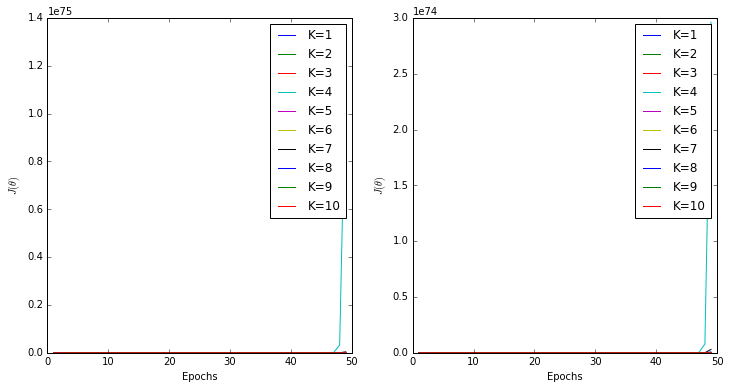

=FINAL RESULTS=

-Stochastic Gradient Descent with 50 epochs, learning rate 1.000000 and convergence criterion 0.001000
	Average MSE on training: 4592858955427808215944862517825591297882712645027909043871557045235350503424.000000 	Best K group: 3 with 36839697948477550793469551791370192258231805579372907709833205057060864.000000
	Average MSE on test: 1125690803699991575576750067849494541943158316566808904767395321242080772096.000000 		Best K group: 3 with 53084411711479159232938958407691748311976834147273139618375340042223616.000000


In [10]:
alpha = 1
gradExp1 = StochasticGradientDescent(iterations, alpha, eps, Plotter(1,2))
experiment1 = KnnExperiment(K, rawdata)
experiment1.process(linearModel, gradExp1)

#### Experiment 2:  Linear Regression and Stochastic Gradient Descent
$$\alpha=0.1$$


Running gradient descent with learning rate: 0.100000
=== Starting Experiment ===

Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.922414 	 Recall: 0.633136 	 Accuracy: 0.845987
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.937984 	 Recall: 0.630208 	 Accuracy: 0.828261
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.936000 	 Recall: 0.672414 	 Accuracy: 0.858696
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.883212 	 Recall: 0.683616 	 Accuracy: 0.843478
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.950820 	 Recall: 0.651685 	 Accuracy: 0.852174
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.927007 	 Recall: 0.668421 	 Accuracy: 0.841304

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


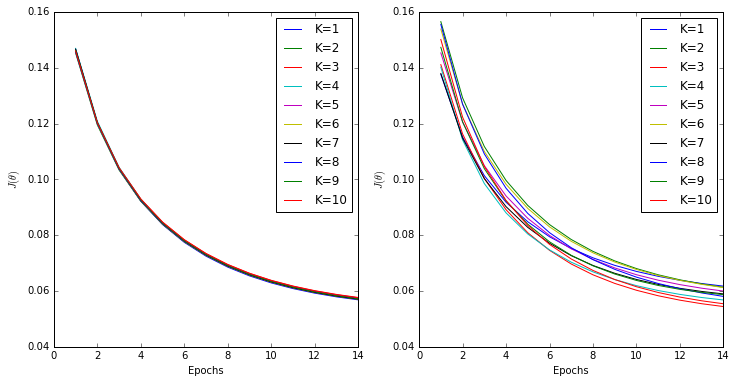

=FINAL RESULTS=

-Stochastic Gradient Descent with 50 epochs, learning rate 0.100000 and convergence criterion 0.001000
	Average MSE on training: 0.056361 	Best K group: 1 with 0.055961
	Average MSE on test: 0.057845 		Best K group: 3 with 0.053611


In [11]:
alpha2 = 0.1
gradExp2 = StochasticGradientDescent(iterations, alpha2, eps, Plotter(1,2))
experiment2 = KnnExperiment(K, rawdata)
experiment2.process(linearModel, gradExp2)

#### Experiment 3:  Linear Regression and Stochastic Gradient Descent
$$\alpha=0.01$$


Running gradient descent with learning rate: 0.010000
=== Starting Experiment ===

Premature stoopage at epoch 41 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.938776 	 Recall: 0.272189 	 Accuracy: 0.726681
Premature stoopage at epoch 40 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.945455 	 Recall: 0.270833 	 Accuracy: 0.689130
Premature stoopage at epoch 40 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.960000 	 Recall: 0.275862 	 Accuracy: 0.721739
Premature stoopage at epoch 41 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.942308 	 Recall: 0.276836 	 Accuracy: 0.715217
Premature stoopage at epoch 41 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.979592 	 Recall: 0.269663 	 Accuracy: 0.715217
Premature stoopage at epoch 40 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.962963 	 Recall: 0.273684 	 Accuracy: 0.695652

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


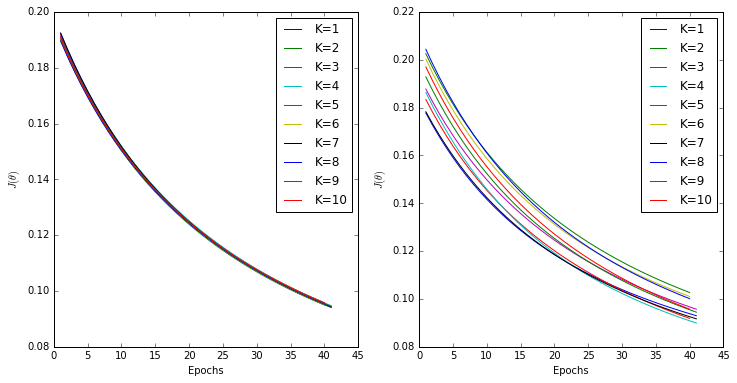

=FINAL RESULTS=

-Stochastic Gradient Descent with 50 epochs, learning rate 0.010000 and convergence criterion 0.001000
	Average MSE on training: 0.093349 	Best K group: 1 with 0.093105
	Average MSE on test: 0.092377 		Best K group: 4 with 0.089021


In [12]:
alpha3 = 0.01
gradExp3 = StochasticGradientDescent(iterations, alpha3, eps, Plotter(1,2))
experiment3 = KnnExperiment(K, rawdata)
experiment3.process(linearModel, gradExp3)

#### Best MSE with Stochastic Gradient Descent

The next table shows the best MSE value for each of the experiments, where the algorithm.

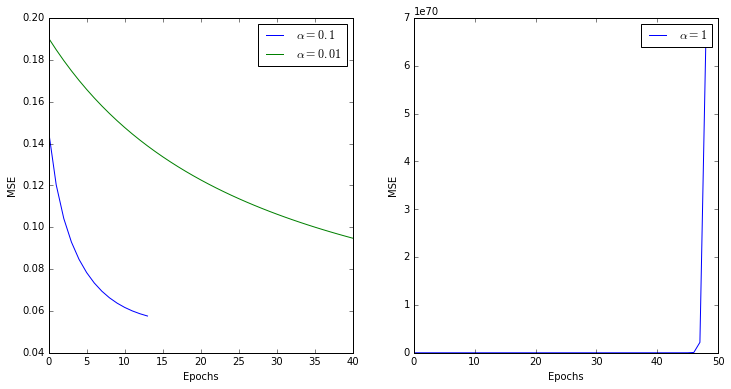

In [13]:
bestSLinear = Plotter(1,2)

bestSLinear.add2DPlot(range(experiment1.bestMSE.shape[0]), experiment1.bestMSE, '$\\alpha=1$', False) \
           .add2DPlot(range(experiment2.bestMSE.shape[0]), experiment2.bestMSE, '$\\alpha=0.1$', True) \
           .add2DPlot(range(experiment3.bestMSE.shape[0]), experiment3.bestMSE, '$\\alpha=0.01$', True)
bestSLinear.show('Epochs','MSE')

#### ROC Analysis: Linear Regression and Stochastic Gradient Descent

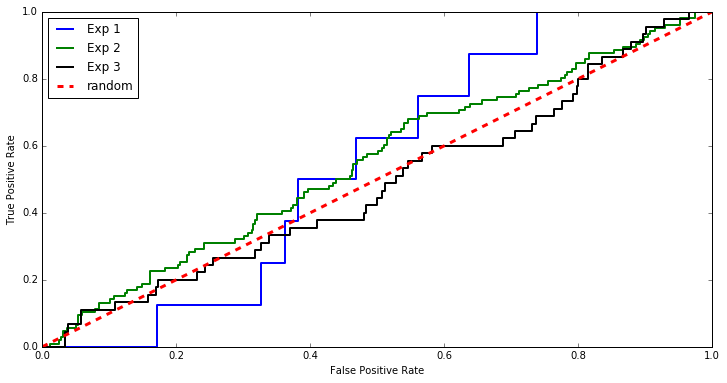

==AROC per Experiment==
==Exp 1: 0.30==
==Exp 2: 0.53==
==Exp 3: 0.48==


In [14]:
evalROCLS1 = Evaluator(linearModel, experiment1.testData[:,0:-1], experiment1.testData[:,-1], experiment1.bestTheta)
tpr_ls1, fpr_ls1, aroc_ls1 = evalROCLS1.getROC()
evalROCLS2 = Evaluator(linearModel, experiment2.testData[:,0:-1], experiment2.testData[:,-1], experiment2.bestTheta)
tpr_ls2, fpr_ls2, aroc_ls2 = evalROCLS2.getROC()
evalROCLS3 = Evaluator(linearModel, experiment3.testData[:,0:-1], experiment3.testData[:,-1], experiment3.bestTheta)
tpr_ls3, fpr_ls3, aroc_ls3 = evalROCLS3.getROC()

plotROCLS = Plotter(1, 1)
plotROCLS.add2DPlot(fpr_ls1, tpr_ls1, 'Exp 1', True, 'blue', 'solid', 2.0)
plotROCLS.add2DPlot(fpr_ls2, tpr_ls2, 'Exp 2', True, 'green', 'solid', 2.0)
plotROCLS.add2DPlot(fpr_ls3, tpr_ls3, 'Exp 3', True, 'black', 'solid', 2.0)
plotROCLS.add2DPlot([0, 1], [0, 1], 'random', True, 'red', 'dashed', 3.0)
plotROCLS.show('False Positive Rate', 'True Positive Rate', 0)

print('==AROC per Experiment==')
print('==Exp 1: %.2f==' %aroc_ls1)
print('==Exp 2: %.2f==' %aroc_ls2)
print('==Exp 3: %.2f==' %aroc_ls3)

#### Linear Regression with Stochastic Gradient Descent: Conclusions

The following table shows the results obtained by processing experiments with different learning rate values.

|Exp #|$\alpha$|Epochs|Average MSE Train|Average MSE Test|AROC|Best|
|-----|:-------|:-----|:----------------|:---------------|:--:|:--:|
|1    |1       |50    |$45e^{73}$       |$11e^{73}$      |0.30|    |
|2    |0.1     |14    |0.056361         |0.057845        |0.53|****|
|3    |0.01    |41    |0.093349         |0.092377        |0.48|    |

#### Experiment 4:  Linear Regression and Batch Gradient Descent
$$\alpha=1$$


Running gradient descent with learning rate: 1.000000
=== Starting Experiment ===

Evaluation 1 fold: Precision: 0.067227 	 Recall: 0.047337 	 Accuracy: 0.409978
Evaluation 2 fold: Precision: 0.084906 	 Recall: 0.046875 	 Accuracy: 0.391304
Evaluation 3 fold: Precision: 0.021739 	 Recall: 0.011494 	 Accuracy: 0.430435
Evaluation 4 fold: Precision: 0.087379 	 Recall: 0.050847 	 Accuracy: 0.430435
Evaluation 5 fold: Precision: 0.075000 	 Recall: 0.050562 	 Accuracy: 0.391304
Evaluation 6 fold: Precision: 0.039604 	 Recall: 0.021053 	 Accuracy: 0.384783
Evaluation 7 fold: Precision: 0.050847 	 Recall: 0.035503 	 Accuracy: 0.402174
Evaluation 8 fold: Precision: 0.078261 	 Recall: 0.046392 	 Accuracy: 0.367391
Evaluation 9 fold: Precision: 0.066667 	 Recall: 0.038251 	 Accuracy: 0.404348
Evaluation 10 fold: Precision: 0.058824 	 Recall: 0.032086 	 Accuracy: 0.397826


/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


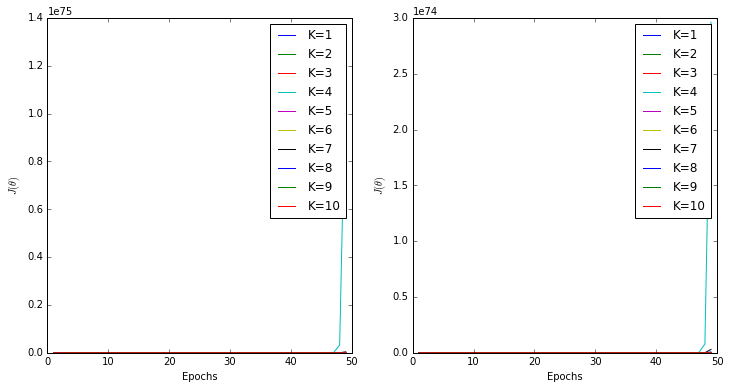

=FINAL RESULTS=

-Stochastic Gradient Descent with 50 epochs, learning rate 1.000000 and convergence criterion 0.001000
	Average MSE on training: 4592858955427833926953570661669999969276190103629549399119457569920715325440.000000 	Best K group: 3 with 36839697948477759212863109552254928993427498021421879858353822026956800.000000
	Average MSE on test: 1125690803699998003328927103810596709791527681217218993579370452413421977600.000000 		Best K group: 3 with 53084411711479441212118477731241686247829829804162925466373821825024000.000000


In [23]:
gradExp4 = BatchGradientDescent(iterations, alpha, eps, Plotter(1,2))

experiment4 = KnnExperiment(K, rawdata)
experiment4.process(linearModel, gradExp4)

#### Experiment 5:  Linear Regression and Batch Gradient Descent
$$\alpha=0.1$$

Running gradient descent with learning rate: 0.100000
=== Starting Experiment ===

Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.922414 	 Recall: 0.633136 	 Accuracy: 0.845987
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.937984 	 Recall: 0.630208 	 Accuracy: 0.828261
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.936000 	 Recall: 0.672414 	 Accuracy: 0.858696
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.883212 	 Recall: 0.683616 	 Accuracy: 0.843478
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.950820 	 Recall: 0.651685 	 Accuracy: 0.852174
Premature stoopage at epoch 14 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.927007 	 Recall: 0.668421 	 Accuracy: 0.841304

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


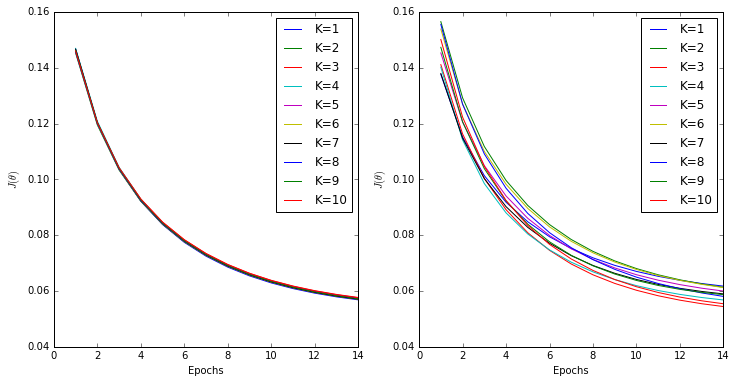

=FINAL RESULTS=

-Stochastic Gradient Descent with 50 epochs, learning rate 0.100000 and convergence criterion 0.001000
	Average MSE on training: 0.056361 	Best K group: 1 with 0.055961
	Average MSE on test: 0.057845 		Best K group: 3 with 0.053611


In [24]:
gradExp5 = BatchGradientDescent(iterations, alpha2, eps, Plotter(1,2))

experiment5 = KnnExperiment(K, rawdata)
experiment5.process(linearModel, gradExp5)

#### Experiment 6:  Linear Regression and Batch Gradient Descent
$$\alpha=0.01$$

Running gradient descent with learning rate: 0.010000
=== Starting Experiment ===

Premature stoopage at epoch 41 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.938776 	 Recall: 0.272189 	 Accuracy: 0.726681
Premature stoopage at epoch 40 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.945455 	 Recall: 0.270833 	 Accuracy: 0.689130
Premature stoopage at epoch 40 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.960000 	 Recall: 0.275862 	 Accuracy: 0.721739
Premature stoopage at epoch 41 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.942308 	 Recall: 0.276836 	 Accuracy: 0.715217
Premature stoopage at epoch 41 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.979592 	 Recall: 0.269663 	 Accuracy: 0.715217
Premature stoopage at epoch 40 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.962963 	 Recall: 0.273684 	 Accuracy: 0.695652

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


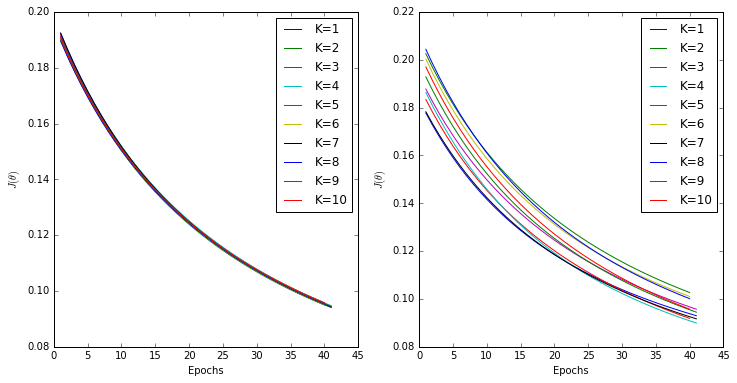

=FINAL RESULTS=

-Stochastic Gradient Descent with 50 epochs, learning rate 0.010000 and convergence criterion 0.001000
	Average MSE on training: 0.093349 	Best K group: 1 with 0.093105
	Average MSE on test: 0.092377 		Best K group: 4 with 0.089021


In [25]:
gradExp6 = BatchGradientDescent(iterations, alpha3, eps, Plotter(1,2))

experiment6 = KnnExperiment(K, rawdata)
experiment6.process(linearModel, gradExp6)

#### Best MSE with Batch Gradient Descent

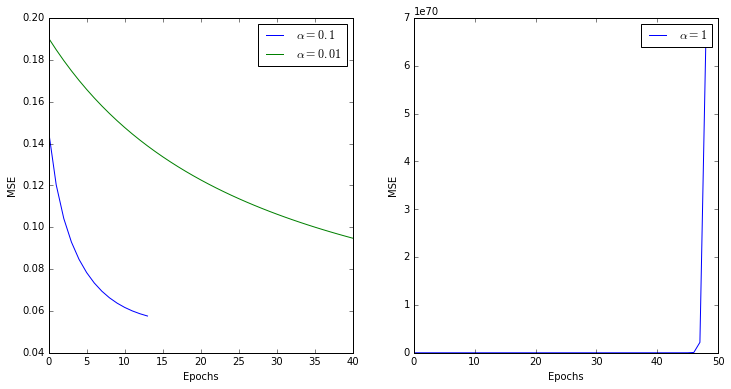

In [26]:
bestBLinear = Plotter(1,2)

bestBLinear.add2DPlot(range(experiment4.bestMSE.shape[0]), experiment4.bestMSE, '$\\alpha=1$', False) \
           .add2DPlot(range(experiment5.bestMSE.shape[0]), experiment5.bestMSE, '$\\alpha=0.1$', True) \
           .add2DPlot(range(experiment6.bestMSE.shape[0]), experiment6.bestMSE, '$\\alpha=0.01$', True)
bestBLinear.show('Epochs','MSE')

#### ROC Analysis: Linear Regression and Batch Gradient Descent

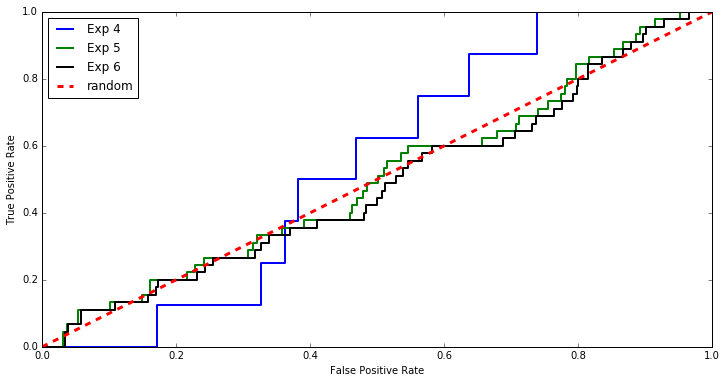

==AROC per Experiment==
==Exp 4: 0.30==
==Exp 5: 0.53==
==Exp 6: 0.48==


In [27]:
evalROCLB1 = Evaluator(linearModel, experiment4.testData[:,0:-1], experiment4.testData[:,-1], experiment4.bestTheta)
tpr_lb1, fpr_lb1, aroc_lb1 = evalROCLB1.getROC()
evalROCLB2 = Evaluator(linearModel, experiment5.testData[:,0:-1], experiment5.testData[:,-1], experiment5.bestTheta)
tpr_lb2, fpr_lb2, aroc_lb2 = evalROCLB2.getROC()
evalROCLB3 = Evaluator(linearModel, experiment6.testData[:,0:-1], experiment6.testData[:,-1], experiment6.bestTheta)
tpr_lb3, fpr_lb3, aroc_lb3 = evalROCLB3.getROC()

plotROCLB = Plotter(1, 1)
plotROCLB.add2DPlot(fpr_lb1, tpr_lb1, 'Exp 4', True, 'blue', 'solid', 2.0)
plotROCLB.add2DPlot(fpr_lb2, tpr_lb3, 'Exp 5', True, 'green', 'solid', 2.0)
plotROCLB.add2DPlot(fpr_lb3, tpr_lb3, 'Exp 6', True, 'black', 'solid', 2.0)
plotROCLB.add2DPlot([0, 1], [0, 1], 'random', True, 'red', 'dashed', 3.0)
plotROCLB.show('False Positive Rate', 'True Positive Rate', 0)

print('==AROC per Experiment==')
print('==Exp 4: %.2f==' %aroc_lb1)
print('==Exp 5: %.2f==' %aroc_lb2)
print('==Exp 6: %.2f==' %aroc_lb3)

#### Linear Regression with Batch Gradient Descent: Conclusions

The following table shows the results obtained by processing experiments with different learning rate values.

|Exp #|$\alpha$|Epochs|Average MSE Train|Average MSE Test|AROC|Best|
|-----|:-------|:-----|:----------------|:---------------|:--:|:--:|
|4    |1       |50    |$36e^{73}$       |$11e^{73}$      |0.30|    |
|5    |0.1     |14    |0.056361         |0.057845        |0.53|****|
|6    |0.01    |41    |0.093349         |0.092377        |0.48|    |

### Logistic Regression: Experimenting with the learning algorithm

The next sections ouline the processed experiments using logistic regression with 10-fold cross validation and different learning rate values.

#### Convergence Criterion

For the  experiments, the convergence parameters were set to a maximum of 100 epochs and a convergence criterion of $1e^{-3}$.

In [15]:
K_l = 10
iterations_l = 100
eps_l = 1e-3
logisticModel = LogisticRegression()

#### Experiment 7:  Logistic Regression and Stochastic Gradient Descent
$$\alpha=1$$


Running gradient descent with learning rate: 1.000000
=== Starting Experiment ===

Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.929577 	 Recall: 0.781065 	 Accuracy: 0.898048
Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.949686 	 Recall: 0.786458 	 Accuracy: 0.893478
Premature stoopage at epoch 25 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.938356 	 Recall: 0.787356 	 Accuracy: 0.900000
Premature stoopage at epoch 25 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.884615 	 Recall: 0.779661 	 Accuracy: 0.876087
Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.964539 	 Recall: 0.764045 	 Accuracy: 0.897826
Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.913043 	 Recall: 0.773684 	 Accuracy: 0.876087

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


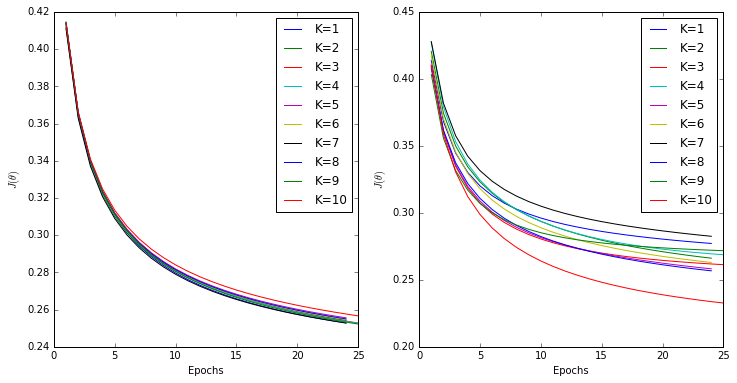

=FINAL RESULTS=

-Stochastic Gradient Descent with 100 epochs, learning rate 1.000000 and convergence criterion 0.001000
	Average MSE on training: 0.252184 	Best K group: 9 with 0.251262
	Average MSE on test: 0.264638 		Best K group: 10 with 0.231690


In [16]:
alpha_l = 1
stochasticGradient_l1 = StochasticGradientDescent(iterations_l, alpha_l, eps_l, Plotter(1, 2))

experiment7 = KnnExperiment(K_l, rawdata)
experiment7.process(logisticModel, stochasticGradient_l1)

#### Experiment 8:  Logistic Regression and Stochastic Gradient Descent
$$\alpha=0.1$$


Running gradient descent with learning rate: 0.100000
=== Starting Experiment ===

Premature stoopage at epoch 58 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.925373 	 Recall: 0.733728 	 Accuracy: 0.880694
Premature stoopage at epoch 57 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.938776 	 Recall: 0.718750 	 Accuracy: 0.863043
Premature stoopage at epoch 58 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.942029 	 Recall: 0.747126 	 Accuracy: 0.886957
Premature stoopage at epoch 57 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.886667 	 Recall: 0.751412 	 Accuracy: 0.867391
Premature stoopage at epoch 58 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.955882 	 Recall: 0.730337 	 Accuracy: 0.882609
Premature stoopage at epoch 57 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.914474 	 Recall: 0.731579 	 Accuracy: 0.860870

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


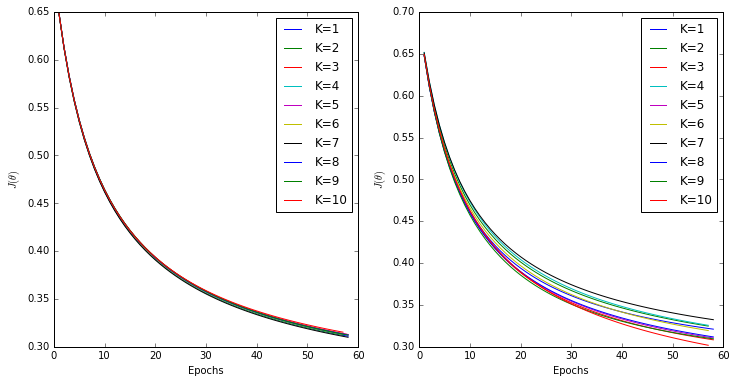

=FINAL RESULTS=

-Stochastic Gradient Descent with 100 epochs, learning rate 0.100000 and convergence criterion 0.001000
	Average MSE on training: 0.310990 	Best K group: 7 with 0.308965
	Average MSE on test: 0.313420 		Best K group: 3 with 0.307405


In [17]:
alpha_l1 = 0.1
stochasticGradient_l2 = StochasticGradientDescent(iterations_l, alpha_l1, eps_l, Plotter(1, 2))

experiment8 = KnnExperiment(K_l, rawdata)
experiment8.process(logisticModel, stochasticGradient_l2)

#### Experiment 9:  Logistic Regression and Stochastic Gradient Descent
$$\alpha=0.01$$


Running gradient descent with learning rate: 0.010000
=== Starting Experiment ===

Evaluation 1 fold: Precision: 0.939394 	 Recall: 0.550296 	 Accuracy: 0.822126
Evaluation 2 fold: Precision: 0.924528 	 Recall: 0.510417 	 Accuracy: 0.778261
Evaluation 3 fold: Precision: 0.933333 	 Recall: 0.563218 	 Accuracy: 0.819565
Evaluation 4 fold: Precision: 0.902655 	 Recall: 0.576271 	 Accuracy: 0.813043
Evaluation 5 fold: Precision: 0.959184 	 Recall: 0.528090 	 Accuracy: 0.808696
Evaluation 6 fold: Precision: 0.935185 	 Recall: 0.531579 	 Accuracy: 0.791304
Evaluation 7 fold: Precision: 0.905263 	 Recall: 0.508876 	 Accuracy: 0.800000
Evaluation 8 fold: Precision: 0.932203 	 Recall: 0.567010 	 Accuracy: 0.800000
Evaluation 9 fold: Precision: 0.962963 	 Recall: 0.568306 	 Accuracy: 0.819565
Evaluation 10 fold: Precision: 0.971963 	 Recall: 0.556150 	 Accuracy: 0.813043


/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


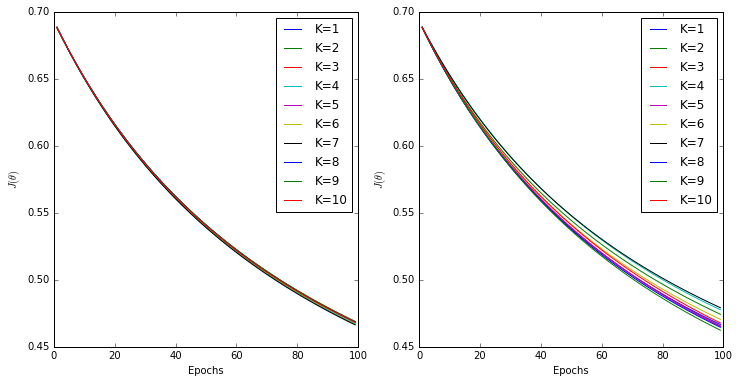

=FINAL RESULTS=

-Stochastic Gradient Descent with 100 epochs, learning rate 0.010000 and convergence criterion 0.001000
	Average MSE on training: 0.467966 	Best K group: 7 with 0.466345
	Average MSE on test: 0.469376 		Best K group: 9 with 0.462366


In [18]:
alpha_l2 = 0.01
stochasticGradient_l2 = StochasticGradientDescent(iterations_l, alpha_l2, eps_l, Plotter(1, 2))

experiment9 = KnnExperiment(K_l, rawdata)
experiment9.process(logisticModel, stochasticGradient_l2)

#### Best MSE with Stochastic Gradient Descent

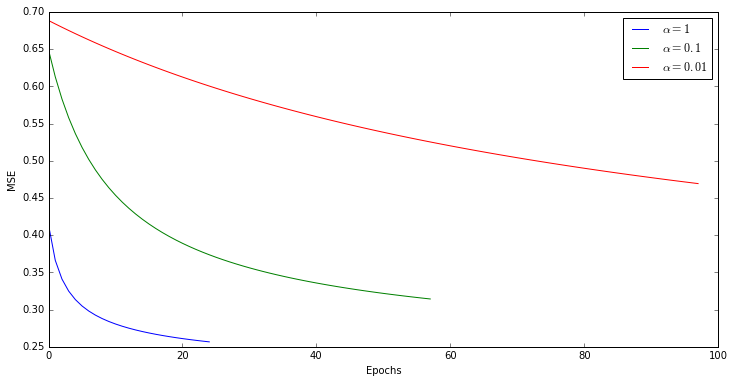

In [21]:
bestSLogistic = Plotter(1,1)

bestSLogistic.add2DPlot(range(experiment7.bestMSE.shape[0]), experiment7.bestMSE, '$\\alpha=1$', True) \
           .add2DPlot(range(experiment8.bestMSE.shape[0]), experiment8.bestMSE, '$\\alpha=0.1$', True) \
           .add2DPlot(range(experiment9.bestMSE.shape[0]), experiment9.bestMSE, '$\\alpha=0.01$', True)
bestSLogistic.show('Epochs','MSE')

#### ROC Analysis: Linear Regression and Stochastic Gradient Descent

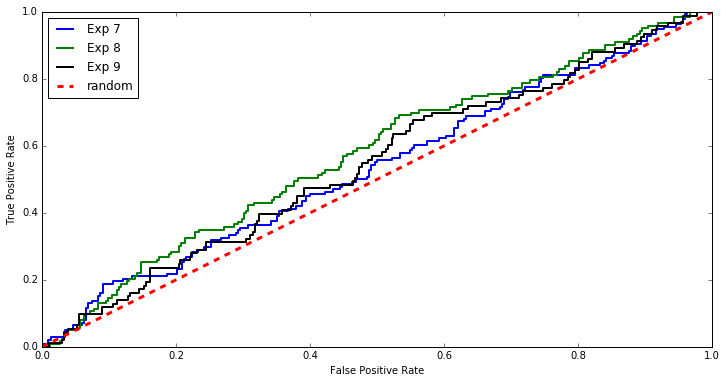

==AROC per Experiment==
==Exp 7: 0.51==
==Exp 8: 0.55==
==Exp 9: 0.53==


In [22]:
evalROCLoS1 = Evaluator(linearModel, experiment7.testData[:,0:-1], experiment7.testData[:,-1], experiment7.bestTheta)
tpr_los1, fpr_los1, aroc_los1 = evalROCLoS1.getROC()
evalROCLoS2 = Evaluator(linearModel, experiment8.testData[:,0:-1], experiment8.testData[:,-1], experiment8.bestTheta)
tpr_los2, fpr_los2, aroc_los2 = evalROCLoS2.getROC()
evalROCLoS3 = Evaluator(linearModel, experiment9.testData[:,0:-1], experiment9.testData[:,-1], experiment9.bestTheta)
tpr_los3, fpr_los3, aroc_los3 = evalROCLoS3.getROC()

plotROCLoS = Plotter(1, 1)
plotROCLoS.add2DPlot(fpr_los1, tpr_los1, 'Exp 7', True, 'blue', 'solid', 2.0)
plotROCLoS.add2DPlot(fpr_los2, tpr_los2, 'Exp 8', True, 'green', 'solid', 2.0)
plotROCLoS.add2DPlot(fpr_los3, tpr_los3, 'Exp 9', True, 'black', 'solid', 2.0)
plotROCLoS.add2DPlot([0, 1], [0, 1], 'random', True, 'red', 'dashed', 3.0)
plotROCLoS.show('False Positive Rate', 'True Positive Rate', 0)

print('==AROC per Experiment==')
print('==Exp 7: %.2f==' %aroc_los1)
print('==Exp 8: %.2f==' %aroc_los2)
print('==Exp 9: %.2f==' %aroc_los3)

#### Logistic Regression with Stochastic Gradient Descent: Conclusions

The following table shows the results obtained by processing experiments with different learning rate values.

|Exp #|$\alpha$|Epochs|Average MSE Train|Average MSE Test|AROC|Best|
|-----|:-------|:-----|:----------------|:---------------|:--:|:--:|
|7    |1       |25    |0.252184         |0.264638        |0.51|    |
|8    |0.1     |58    |0.310990         |0.313420        |0.55|****|
|9    |0.01    |100   |0.467966         |0.469376        |0.53|    |

#### Experiment 10:  Logistic Regression and Batch Gradient Descent
$$\alpha=1$$

Running gradient descent with learning rate: 1.000000
=== Starting Experiment ===

Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.929577 	 Recall: 0.781065 	 Accuracy: 0.898048
Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.949686 	 Recall: 0.786458 	 Accuracy: 0.893478
Premature stoopage at epoch 25 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.938356 	 Recall: 0.787356 	 Accuracy: 0.900000
Premature stoopage at epoch 25 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.884615 	 Recall: 0.779661 	 Accuracy: 0.876087
Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.964539 	 Recall: 0.764045 	 Accuracy: 0.897826
Premature stoopage at epoch 24 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.913043 	 Recall: 0.773684 	 Accuracy: 0.876087

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


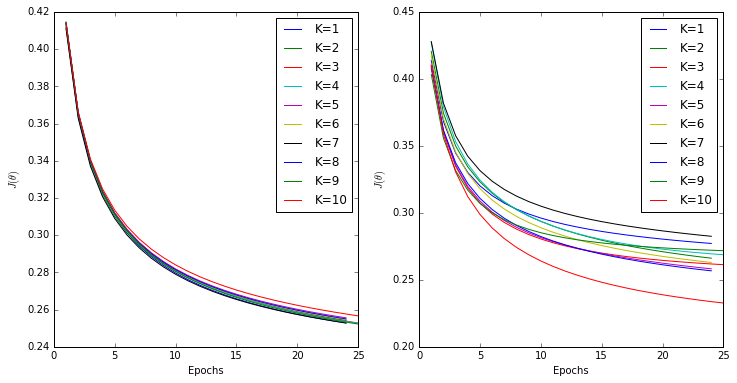

=FINAL RESULTS=

-Stochastic Gradient Descent with 100 epochs, learning rate 1.000000 and convergence criterion 0.001000
	Average MSE on training: 0.252184 	Best K group: 9 with 0.251262
	Average MSE on test: 0.264638 		Best K group: 10 with 0.231690


In [28]:
batchGradient_l = BatchGradientDescent(iterations_l, alpha_l, eps_l, Plotter(1, 2))

experiment10 = KnnExperiment(K_l, rawdata)
experiment10.process(logisticModel, batchGradient_l)

#### Experiment 11:  Logistic Regression and Batch Gradient Descent
$$\alpha=0.1$$

Running gradient descent with learning rate: 0.100000
=== Starting Experiment ===

Premature stoopage at epoch 58 due to model reached convergence criterion
Evaluation 1 fold: Precision: 0.925373 	 Recall: 0.733728 	 Accuracy: 0.880694
Premature stoopage at epoch 57 due to model reached convergence criterion
Evaluation 2 fold: Precision: 0.938776 	 Recall: 0.718750 	 Accuracy: 0.863043
Premature stoopage at epoch 58 due to model reached convergence criterion
Evaluation 3 fold: Precision: 0.942029 	 Recall: 0.747126 	 Accuracy: 0.886957
Premature stoopage at epoch 57 due to model reached convergence criterion
Evaluation 4 fold: Precision: 0.886667 	 Recall: 0.751412 	 Accuracy: 0.867391
Premature stoopage at epoch 58 due to model reached convergence criterion
Evaluation 5 fold: Precision: 0.955882 	 Recall: 0.730337 	 Accuracy: 0.882609
Premature stoopage at epoch 57 due to model reached convergence criterion
Evaluation 6 fold: Precision: 0.914474 	 Recall: 0.731579 	 Accuracy: 0.860870

/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


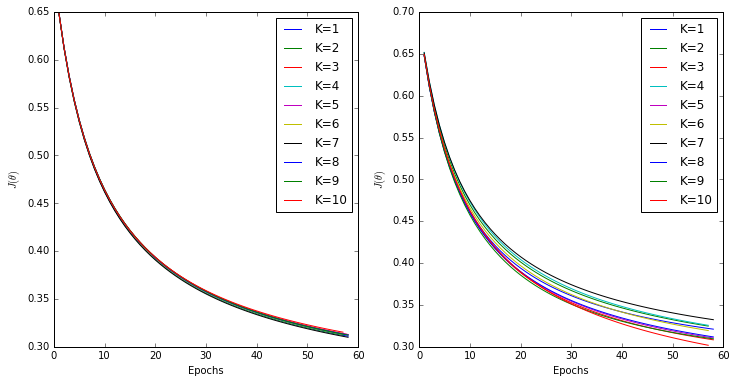

=FINAL RESULTS=

-Stochastic Gradient Descent with 100 epochs, learning rate 0.100000 and convergence criterion 0.001000
	Average MSE on training: 0.310990 	Best K group: 7 with 0.308965
	Average MSE on test: 0.313420 		Best K group: 3 with 0.307405


In [46]:
batchGradient_l2 = BatchGradientDescent(iterations_l, alpha_l1, eps_l, Plotter(1, 2))

experiment11 = KnnExperiment(K_l, rawdata)
experiment11.process(logisticModel, batchGradient_l2)

#### Experiment 12:  Logistic Regression and Batch Gradient Descent
$$\alpha=0.01$$

Running gradient descent with learning rate: 0.010000
=== Starting Experiment ===

Evaluation 1 fold: Precision: 0.939394 	 Recall: 0.550296 	 Accuracy: 0.822126
Evaluation 2 fold: Precision: 0.924528 	 Recall: 0.510417 	 Accuracy: 0.778261
Evaluation 3 fold: Precision: 0.933333 	 Recall: 0.563218 	 Accuracy: 0.819565
Evaluation 4 fold: Precision: 0.902655 	 Recall: 0.576271 	 Accuracy: 0.813043
Evaluation 5 fold: Precision: 0.959184 	 Recall: 0.528090 	 Accuracy: 0.808696
Evaluation 6 fold: Precision: 0.935185 	 Recall: 0.531579 	 Accuracy: 0.791304
Evaluation 7 fold: Precision: 0.905263 	 Recall: 0.508876 	 Accuracy: 0.800000
Evaluation 8 fold: Precision: 0.932203 	 Recall: 0.567010 	 Accuracy: 0.800000
Evaluation 9 fold: Precision: 0.962963 	 Recall: 0.568306 	 Accuracy: 0.819565
Evaluation 10 fold: Precision: 0.971963 	 Recall: 0.556150 	 Accuracy: 0.813043


/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/santteegt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


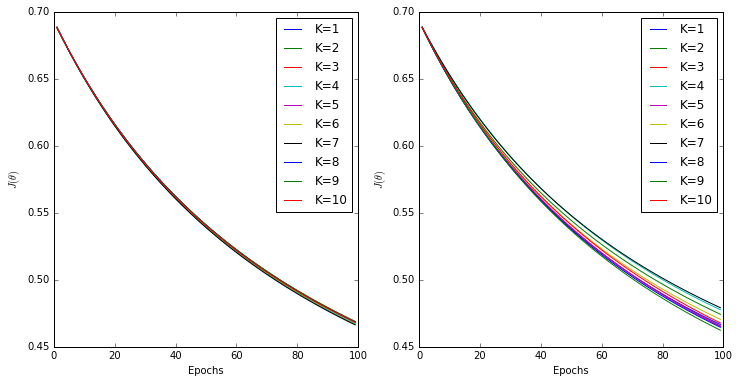

=FINAL RESULTS=

-Stochastic Gradient Descent with 100 epochs, learning rate 0.010000 and convergence criterion 0.001000
	Average MSE on training: 0.467966 	Best K group: 7 with 0.466345
	Average MSE on test: 0.469376 		Best K group: 9 with 0.462366


In [43]:
batchGradient_l3 = BatchGradientDescent(iterations_l, alpha_l2, eps_l, Plotter(1, 2))

experiment12 = KnnExperiment(K_l, rawdata)
experiment12.process(logisticModel, batchGradient_l3)

#### Best MSE with Stochastic Gradient Descent

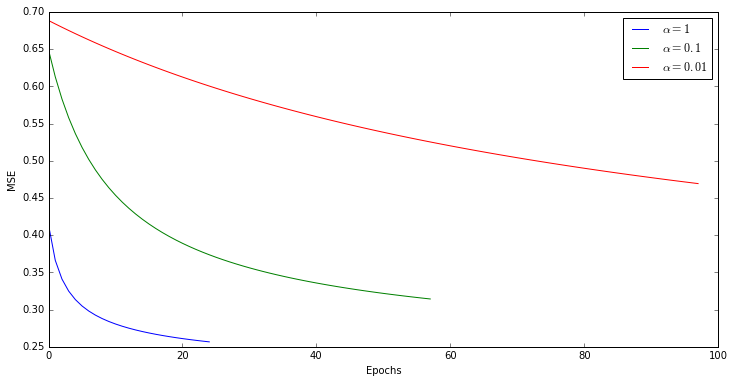

In [47]:
bestBLogistic = Plotter(1,1)

bestBLogistic.add2DPlot(range(experiment10.bestMSE.shape[0]), experiment10.bestMSE, '$\\alpha=1$', True) \
           .add2DPlot(range(experiment11.bestMSE.shape[0]), experiment11.bestMSE, '$\\alpha=0.1$', True) \
           .add2DPlot(range(experiment12.bestMSE.shape[0]), experiment12.bestMSE, '$\\alpha=0.01$', True)
bestBLogistic.show('Epochs','MSE')

#### ROC Analysis: Linear Regression and Stochastic Gradient Descent

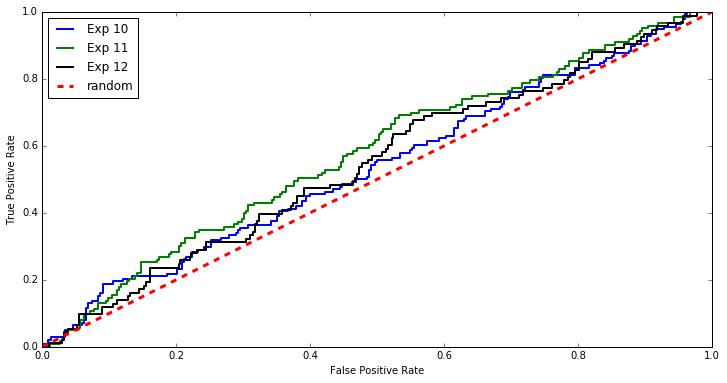

==AROC per Experiment==
==Exp 10: 0.51==
==Exp 11: 0.55==
==Exp 12: 0.53==


In [48]:
evalROCLoB1 = Evaluator(linearModel, experiment10.testData[:,0:-1], experiment10.testData[:,-1], experiment10.bestTheta)
tpr_lob1, fpr_lob1, aroc_lob1 = evalROCLoB1.getROC()
evalROCLoB2 = Evaluator(linearModel, experiment11.testData[:,0:-1], experiment11.testData[:,-1], experiment11.bestTheta)
tpr_lob2, fpr_lob2, aroc_lob2 = evalROCLoB2.getROC()
evalROCLoB3 = Evaluator(linearModel, experiment12.testData[:,0:-1], experiment12.testData[:,-1], experiment12.bestTheta)
tpr_lob3, fpr_lob3, aroc_lob3 = evalROCLoB3.getROC()

plotROCLoB = Plotter(1, 1)
plotROCLoB.add2DPlot(fpr_lob1, tpr_lob1, 'Exp 10', True, 'blue', 'solid', 2.0)
plotROCLoB.add2DPlot(fpr_lob2, tpr_lob2, 'Exp 11', True, 'green', 'solid', 2.0)
plotROCLoB.add2DPlot(fpr_lob3, tpr_lob3, 'Exp 12', True, 'black', 'solid', 2.0)
plotROCLoB.add2DPlot([0, 1], [0, 1], 'random', True, 'red', 'dashed', 3.0)
plotROCLoB.show('False Positive Rate', 'True Positive Rate', 0)

print('==AROC per Experiment==')
print('==Exp 10: %.2f==' %aroc_lob1)
print('==Exp 11: %.2f==' %aroc_lob2)
print('==Exp 12: %.2f==' %aroc_lob3)

#### Logistic Regression with Batch Gradient Descent: Conclusions

The following table shows the results obtained by processing experiments with different learning rate values.

|Exp #|$\alpha$|Epochs|Average MSE Train|Average MSE Test|AROC|Best|
|-----|:-------|:-----|:----------------|:---------------|:--:|:--:|
|10   |1       |25    |0.252184         |0.264638        |0.51|    |
|11   |0.1     |58    |0.310990         |0.313420        |0.55|****|
|12   |0.01    |100   |0.467966         |0.469376        |0.53|    |

### Conclusions

The following table outlines a summary of the results obtained by processing experiments using Linear Regression and Logistic Regression with different learning rate values. The best trained model was chosen by comparing the accuracy of the predictions on the test set. This model was trained by running 58 epoch of a Logistic Regression with a learning rate of 0.1, obtaining a 88.69% accuracy. It also got the maximum AROC value among experiments, but it is important to mention that there this measure is not always reliable on classification tasks, as some critisism have been made by the community.

|Experiments       |$\alpha$|Epochs|Average MSE Test|Precision|Accuracy|AROC|Best|
|------------------|:-------|:-----|:---------------|:--------|--------|:--:|:--:|
|Linear Regression |1       |50    |$11e^{73}$      |8.73%    |43.04%  |0.30|    |
|Linear Regression |0.1     |14    |0.057845        |93.6%    |85.86%  |0.53|    |
|Linear Regression |0.01    |41    |0.092377        |96%      |72.17%  |0.48|    |
|Logistic Regr.    |1       |25    |0.264638        |96.20%   |91.08%  |0.51|    |
|Logistic Reg.     |0.1     |58    |0.313420        |94.20%   |88.69%  |0.55|****|
|Logistic Reg.     |0.01    |100   |0.469376        |55.02%   |81.21%  |0.53|    |


